In [86]:
import time,json,os
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
from tqdm.notebook import tqdm_notebook
from common import preprocess,get_csv_files
from warnings import filterwarnings
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
from scipy.stats import ks_2samp
from scipy.stats import wasserstein_distance
from scipy.stats import stats
from scipy.spatial.distance import pdist
from sklearn.metrics.pairwise import cosine_similarity
filterwarnings("ignore") 
np.set_printoptions(suppress=True)
pd.set_option('display.float_format',lambda x : '%.8f' % x)
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline

In [87]:
def show_heatmap(df):
    plt.style.use({'figure.figsize':(16, 6)})
    plt.ticklabel_format(style='plain',axis='both')
    cmap = sns.cubehelix_palette(start = 1, rot = 3, gamma=0.8, as_cmap = True)
    sns.heatmap(df, cmap = cmap, linewidths = 0.05,annot=False, fmt="g",annot_kws={"fontsize":16})
    plt.xticks(rotation=60)
    plt.yticks(rotation=60)

In [88]:
def get_histogram(df , with_preprocess = True):
    if with_preprocess:
        df_tmp = preprocess(df)
    else:
        df_tmp = df.copy( deep = True )
    del df_tmp['label']
    ret_df = pd.DataFrame()
    ret_series = pd.Series()
    for key in df_tmp.keys():
        #hist, bin_edges = np.histogram(df_tmp[key],bins=15*len(df.keys()), density=True)
        hist, bin_edges = np.histogram( df_tmp[key] , bins = 20 * len(df_tmp.keys()) )
        ret_df[key] = pd.Series(hist) 
        #cate = pd.qcut( ret_df[key],10,labels=False,duplicates='drop',precision=8)
        #cate.fillna(-1,inplace=True)
        #ret_df[key] = cate
        ret_df[key] = ( ret_df[key] - ret_df[key].min() ) / ( ret_df[key].max()-ret_df[key].min() ) 
        #ret_df[key] = (ret_df[key] - ret_df[key].mean())/ ret_df[key].std()
        ret_series = ret_series.append(ret_df[key], ignore_index=True)

    return ret_df.T,ret_series.reset_index(drop=True)

In [89]:
class CJSimilarity(object):
    def __init__(self,list1,list2):
        self.m_list1 = list1
        self.m_list2 = list2
    
    #余弦距离（cosine）
    def Cosine(self):
        ret = cosine_similarity([self.m_list1, self.m_list2])
        return ret[0][1]
        return cosine(self.m_list1, self.m_list2)
    
    #皮尔森相关系数（pearson）,https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html
    def Pearson(self):
        return stats.pearsonr(self.m_list1, self.m_list2)[0]
    
    #欧式距离
    def Euclidean(self):
        return np.linalg.norm(np.array(self.m_list1) - np.array(self.m_list2))

    #KS检验,(P越大，两个分布越相似)
    #P比指定的显著水平（假设为5%）小，则我们完全可以拒绝假设，即两个分布不服从同一分布。
    def KSTest(self):
        ret = ks_2samp(self.m_list1, self.m_list2)
        return ret[0],ret[1]
    
    #EDM距离
    def EDM(self):
        return wasserstein_distance(self.m_list1, self.m_list2)
    
    #Manhattan
    def Manhattan(self):
        return sum(abs(a-b) for a,b in zip(self.m_list1,self.m_list2))
    
    #Minkowski
    def Minkowski(self):
        return float(self.minkowski_distance(np.array(self.m_list1),np.array(self.m_list2),3))
    
    #Jaccard
    def Jaccard(self):
        return self.jaccard_similarity(self.m_list1,self.m_list2)
    
    def minkowski_distance(self,x,y,p_value):
        return self.nth_root(sum(pow(abs(a-b),p_value) for a,b in zip(x, y)),p_value)
    
    def nth_root(self,value, n_root):
        root_value = 1/float(n_root)
        return round (float(value) ** float(root_value),3)
    
    def jaccard_similarity(self,x,y):
        intersection_cardinality = len(set.intersection(*[set(x), set(y)]))
        union_cardinality = len(set.union(*[set(x), set(y)]))
        return intersection_cardinality/float(union_cardinality)
    
    #def Quadratic(self):
    #    return get_quadratic_distance(self.m_list1,self.m_list2)

In [90]:
csv_list = []
get_csv_files("/data/paper/sample/",csv_list)
csv_list.sort()
train_hist = {}
test_hist = {}
print("Calculating histogram...")
bar = tqdm(total=len(csv_list))
for fi in csv_list:
    dataset = os.path.splitext(os.path.basename(fi))[0]
    df = pd.read_csv(fi,index_col=0)
    df_hist,ds_hist = get_histogram(df)
    test_hist[dataset] = {}
    test_hist[dataset]['df_hist'] = df_hist
    test_hist[dataset]['ds_hist'] = ds_hist
    if dataset.split("-")[-1] != '0':
        bar.update(1)
        continue
    train_hist[dataset] = {}
    train_hist[dataset]['df_hist'] = df_hist
    train_hist[dataset]['ds_hist'] = ds_hist
    bar.update(1)

Calculating histogram...


  0%|          | 0/64 [00:00<?, ?it/s]

In [91]:
all_similarity = []
print("Calculating distance ...")
bar = tqdm(total=len(train_hist))
for d1 in train_hist:
    for d2 in test_hist:
        s = CJSimilarity(train_hist[d1]['ds_hist'].tolist(),test_hist[d2]['ds_hist'].tolist())
        tmp = {}
        tmp['D1'] = d1
        tmp['D2'] = d2
        tmp['Cosine'] = s.Cosine()
        tmp['Pearson'] = s.Pearson()
        tmp['Euclidean'] = s.Euclidean()
        tmp['EDM'] = s.EDM()
        tmp['KS'] = s.KSTest()[1]
        tmp['Manhattan'] = s.Manhattan()
        tmp['Minkowski'] = s.Minkowski()
        tmp['Jaccard'] = s.Jaccard()
        #tmp['Qaccard'] = s.Quadratic()

        all_similarity.append(tmp)
    bar.update( 1 )
df_similarity = pd.DataFrame(all_similarity)
df_similarity.to_csv("/data/paper/analyse/similarity.csv")

Calculating distance ...


  0%|          | 0/16 [00:00<?, ?it/s]

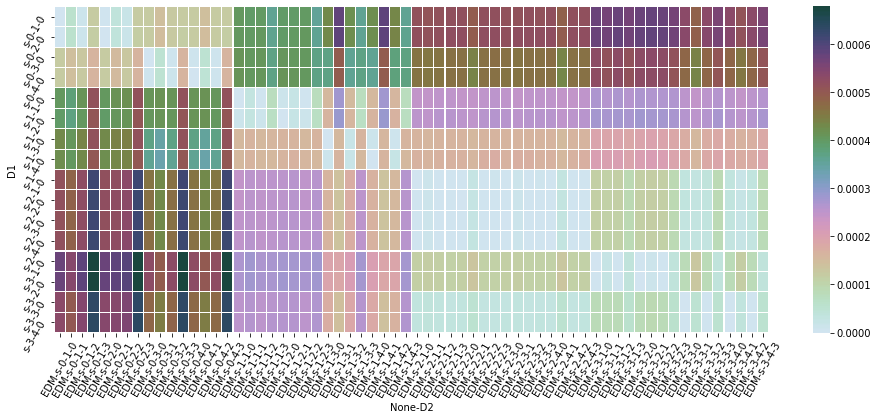

In [92]:
pt = df_similarity.pivot_table(index='D1', columns=['D2'],  values=['EDM'],aggfunc=np.mean)
show_heatmap(pt)

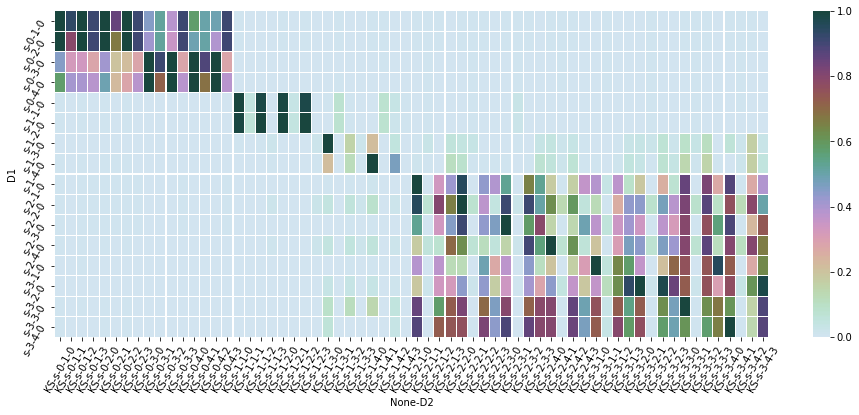

In [93]:
pt = df_similarity.pivot_table(index='D1', columns=['D2'],  values=['KS'],aggfunc=np.mean)
show_heatmap(pt)

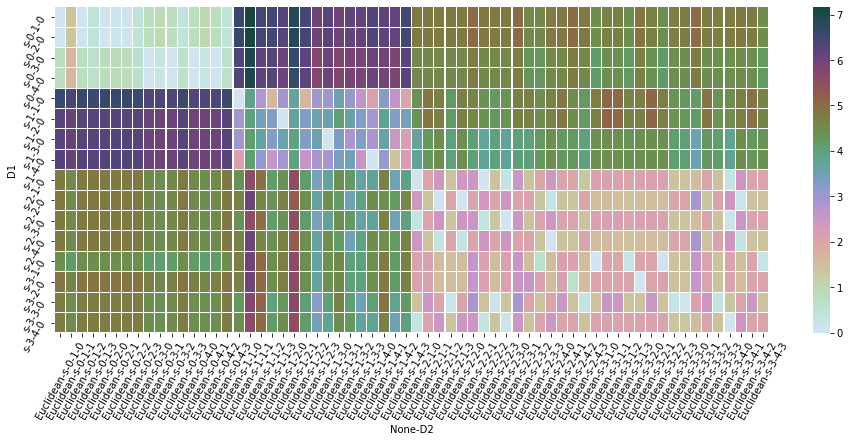

In [94]:
pt = df_similarity.pivot_table(index='D1', columns=['D2'],  values=['Euclidean'],aggfunc=np.mean)
show_heatmap(pt)

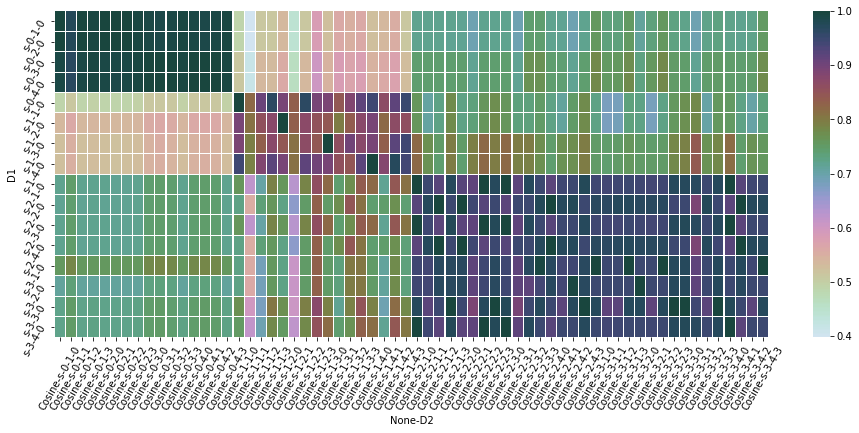

In [95]:
pt = df_similarity.pivot_table(index='D1', columns=['D2'],  values=['Cosine'],aggfunc=np.mean)
show_heatmap(pt)

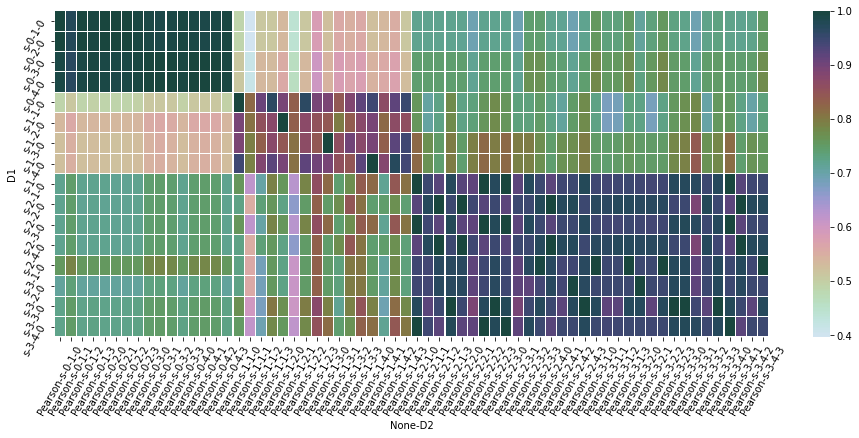

In [96]:
pt = df_similarity.pivot_table(index='D1', columns=['D2'],  values=['Pearson'],aggfunc=np.mean)
show_heatmap(pt)

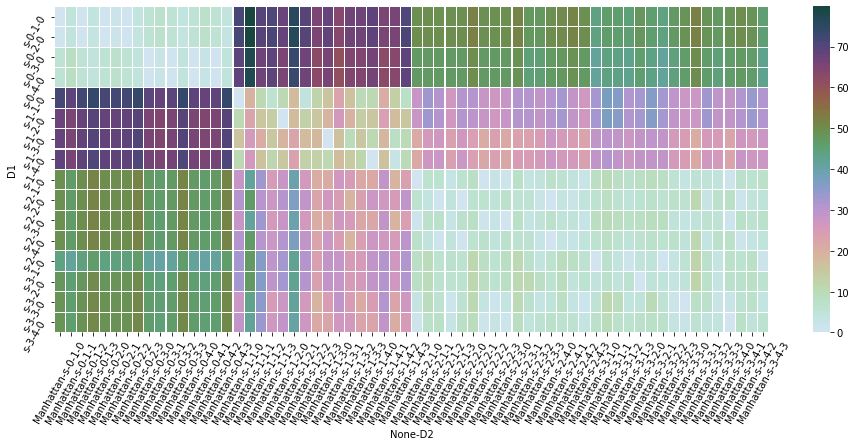

In [97]:
pt = df_similarity.pivot_table(index='D1', columns=['D2'],  values=['Manhattan'],aggfunc=np.mean)
show_heatmap(pt)

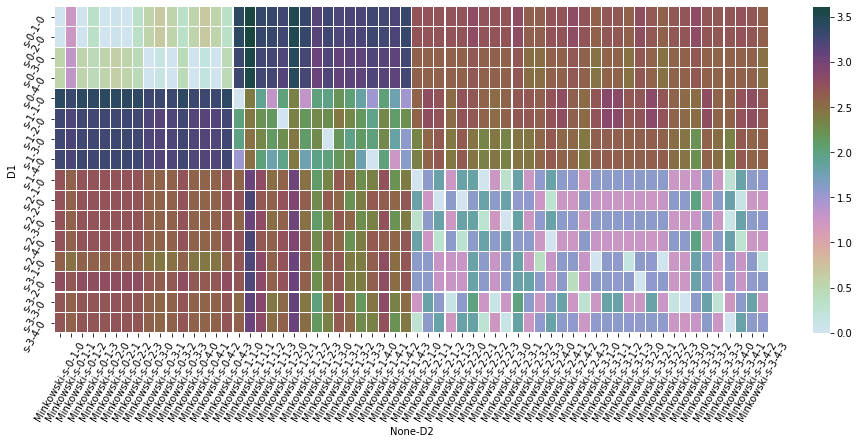

In [98]:
pt = df_similarity.pivot_table(index='D1', columns=['D2'],  values=['Minkowski'],aggfunc=np.mean)
show_heatmap(pt)

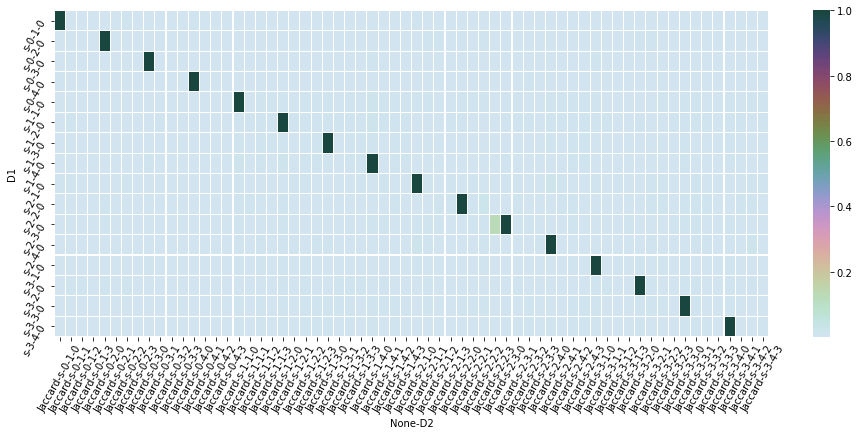

In [99]:
pt = df_similarity.pivot_table(index='D1', columns=['D2'],  values=['Jaccard'],aggfunc=np.mean)
show_heatmap(pt)

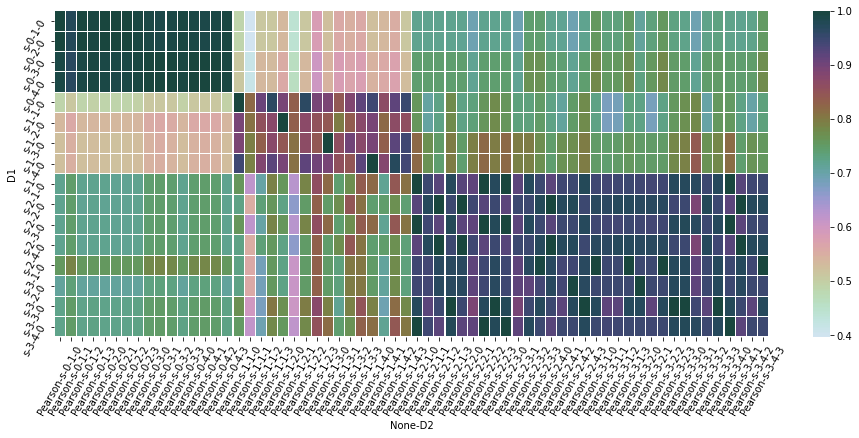

In [100]:
pt = df_similarity.pivot_table(index='D1', columns=['D2'],  values=['Pearson'],aggfunc=np.mean)
show_heatmap(pt)

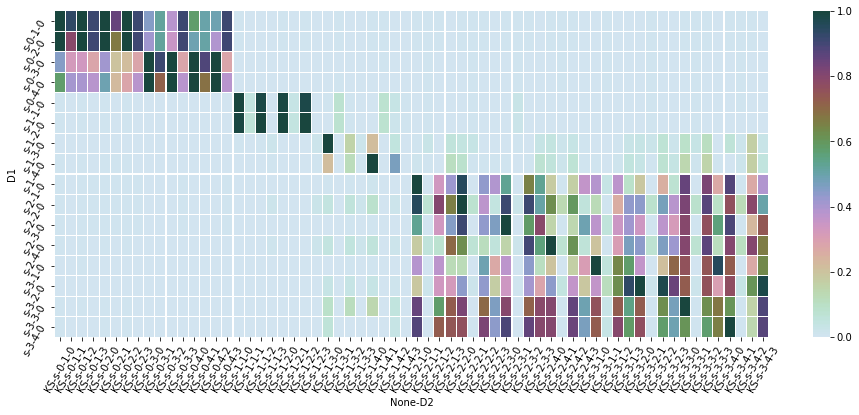

In [101]:
pt = df_similarity.pivot_table(index='D1', columns=['D2'],  values=['KS'],aggfunc=np.mean)
show_heatmap(pt)

In [102]:
#显示所有行
pd.set_option('display.max_rows', None)
#设置value的显示长度为100，默认为50
pd.set_option('max_colwidth',100)
df_similarity[df_similarity['D1']=='s-3-1-0.csv'].sort_values(by='EDM').reset_index(drop=True)['D2']

Series([], Name: D2, dtype: object)